In [172]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
!curl -o keren.tar.gz https://storage.googleapis.com/bebi205-spring2023/keren.tar.gz
!tar -xzvf keren.tar.gz

In [3]:
meta = 0
with open('./keren/meta.yaml', 'r') as stream:
    meta = yaml.safe_load(stream)

In [4]:
def histogram_equalization(image, number_bins=256):
    histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = histogram.cumsum()
    cdf = (number_bins-1) * cdf / cdf[-1]
    equalized = np.interp(image.flatten(), bins[:-1], cdf)
    return equalized.reshape(image.shape)

In [31]:
#cells = []
cell_areas = []
types = []
good_ctypes = [i for i in range(17) if i not in [0,1,17]]
good_channels = [i for i in range(51) if i not in [0,3,21,23,35,37,42,43,48]]
cell_sums = np.zeros((0, len(good_channels)))
marker_panel = np.zeros((len(good_ctypes), len(good_channels)))
marker_panel_count = np.zeros((len(good_ctypes), len(good_channels)))
for root, subdir, files in os.walk('./keren'):
    lim = 20
    cur = 0
    for fname in files[1:]:
        if lim > cur:
            with np.load(os.path.join(root,fname), allow_pickle=True) as f:
                Xf = np.asarray(f['X'])
                Xfnorm = np.zeros_like(Xf).squeeze()
                for channel in good_channels:
                    Xfnorm[:,:,channel] = histogram_equalization(Xf[0,:,:,channel])
                yf = np.asarray(f['y'])
                ctypes = f['cell_types'].tolist()
                for cell in range(yf[0,:,:,1].max()):
                    if ctypes[cell] not in good_ctypes:
                        continue
                    cell_bin = np.argwhere(yf[0,:,:,1] == cell)
                    cell_binary = (yf[0,:,:,1] == cell)
                    cell_area = np.sum(cell_binary)
                    xmin,ymin = cell_bin.min(axis=0)
                    xmax,ymax = cell_bin.max(axis=0)
                    cview = Xfnorm[xmin:xmax+1, ymin:ymax+1, good_channels]
                  # cells.append(cview)
                    cell_areas.append(cell_area)
                    types.append(ctypes[cell])
                    ch_sums = np.zeros((1,len(good_channels)))
                    for ch_ind in range(len(good_channels)):
                        ch_sums[0, ch_ind] = (cview[:,:,ch_ind] *\
                                           (cell_binary[xmin:xmax+1, ymin:ymax+1])).sum()
                        marker_panel[ctypes[cell]-2, ch_ind] += ch_sums[0, ch_ind]/cell_area
                        marker_panel_count[ctypes[cell]-2, ch_ind] += 1
                    cell_sums = np.concatenate((cell_sums, ch_sums))
            cur += 1
marker_panel_count = np.maximum(marker_panel_count, np.ones_like(marker_panel_count))
marker_panel = marker_panel / marker_panel_count

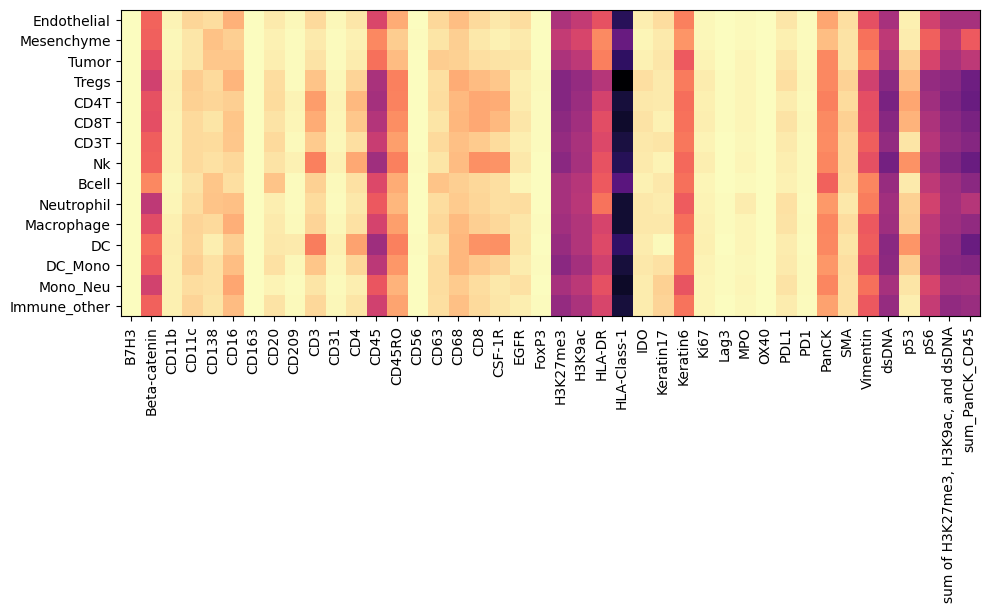

In [39]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(len(good_channels)),
           np.array(meta['channels'])[good_channels], rotation=90)
plt.yticks(np.arange(len(good_ctypes)),
           np.array(list(meta['cell_types'].values()))[good_ctypes])
plt.imshow(marker_panel, cmap='magma')
plt.tight_layout()

In [97]:
class CellMarkerDataset(Dataset):
    def __init__(self, labels, markers, transform=None, target_transform=None):
        self.labels = labels
        self.marker_data = markers
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.marker_data[idx,:]), self.labels[idx]

In [238]:
types_1hot = np.zeros((len(types),17))
for i, ty in enumerate(types):
    types_1hot[i,ty] = 1
dataset = CellMarkerDataset(types_1hot, cell_sums/((cell_sums.max(axis=1).reshape((92901,1)))))
batch_size = 8
train_test_extra = random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_loader = DataLoader(train_test_extra[0], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_test_extra[1], batch_size=batch_size, shuffle=False)

In [239]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(len(good_channels), 34)
        self.lin2 = nn.Linear(34, 27)
        self.lin3 = nn.Linear(27, 21)
        self.lin4 = nn.Linear(21, 17)
    
    def forward(self, x):
        x = torch.Tensor(x.type(torch.float))
        x = F.relu(F.dropout(self.lin1(x)))
        x = F.relu(F.dropout(self.lin2(x)))
        x = F.relu(F.dropout(self.lin3(x)))
        x = self.lin4(x)
        return F.softmax(x, dim=1)

net = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [240]:
for epoch in range(20):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
    if epoch % 5 == 4:
        print('Epoch:', epoch+1)
        
print('Finished Training')

Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Finished Training


In [241]:
path = './HW1_net.pth'
torch.save(net.state_dict(), path)

In [242]:
correct = 0
total = 0
preds = []
truth = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        _, true_labels = torch.max(labels, 1)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted)
        truth.extend(true_labels)
        total += true_labels.size(0)
        correct += (predicted == true_labels).sum().item()

print(f'Accuracy on the test set: {100 * correct // total} %')

Accuracy on the test set: 54 %


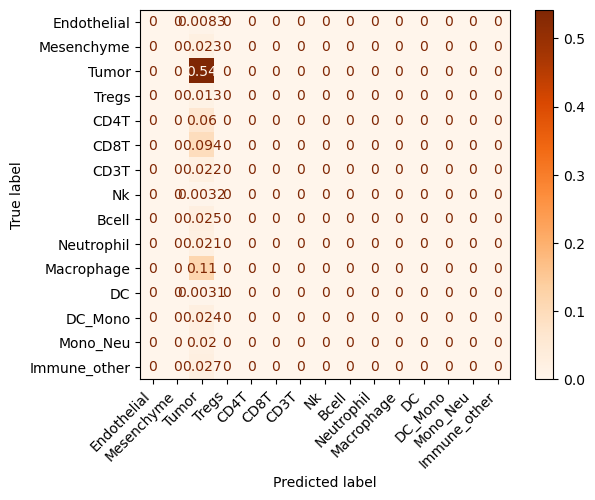

In [243]:
word_truth = [meta['cell_types'][int(t)] for t in truth]
word_preds = [meta['cell_types'][int(p)] for p in preds]
ConfusionMatrixDisplay.from_predictions(word_truth, word_preds, 
                                        labels=list(meta['cell_types'].values())[2:17], 
                                        normalize='all', cmap='Oranges')
plt.xticks(rotation=45, ha='right')
plt.show()